# Lesson 03 Simple metrics and grid size

*This lesson made by Simon M Mudd and last updated 22/11/2021*

In this lesson we are going to look at some simple topographic metrics and how the grid size affects these metrics. 

**Side note**: The grid cell size in a geospatial raster is the length of the edges of each pixel. This is often referred to as the "resolution" but technically the resolution is defined as the minimum distance between two objects that can be separated in an image, so the resolution of a raster is larger than the grid cell size. [You can read about that here](https://www.semanticscholar.org/paper/The-differentiation-between-grid-spacing-and-and-to-Grasso/23ed9f85a67dea01eb6501701478555721b6af13).

You will need to have data files from the previous lessons, so if you have not done those lessons please open them and execute the cells (the quick way to do that is to use the `Restart & run all` button in the `Kernel` menu above). 

## First import some stuff we need

First we make sure lsdviztools version is updated (it needs to be > 0.4.7):

In [1]:
!pip install lsdviztools --upgrade

     |████████████████████████████████| 271 kB 4.6 MB/s eta 0:00:01
  Attempting uninstall: lsdviztools
    Found existing installation: lsdviztools 0.4.6
    Uninstalling lsdviztools-0.4.6:
      Successfully uninstalled lsdviztools-0.4.6


Now import stuff we need. 

In [2]:
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt

## Grab some (more) data

We are going to grab a few more datasets. These will be in the same area, but they will be a 90 m dataset and a different 30 m dataset. They require 2 different calls to the `ot_scraper` in `lsdviztools`.

In [3]:
lower_left = [36.990554387425014, -2.318307057720176]
upper_right = [37.23367133834253, -1.8425313329873874]

In [4]:
# This downloads 90m (3 arcsecond) SRTM
Aguas_DEM = bmt.ot_scraper(source = "SRTMGL3",
                           lower_left_coordinates = lower_left, 
                           upper_right_coordinates = upper_right,
                           prefix = "rio_aguas") 
Aguas_DEM.print_parameters()
Aguas_DEM.download_pythonic()

I am taking your coordinates from the lower left list
I am taking your coordinates from the upper right list
Your source is a 90m DEM.
The source is: SRTMGL3
The west longitude is: -2.318307057720176
The east longitude is: -1.8425313329873874
The south latitude is: 37.23367133834253
The north latitude is: 36.990554387425014
The path is: ./
The prefix is: rio_aguas
The resolution is: 90
I am going to download the following for you:
https://portal.opentopography.org/API/globaldem?demtype=SRTMGL3&south=36.990554387425014&north=37.23367133834253&west=-2.318307057720176&east=-1.8425313329873874&outputFormat=GTiff
This might take a little while, depending on the size of the file. 
The filename will be:
./rio_aguas_SRTMGL3.tif
The path and file without path are:
./  rio_aguas_SRTMGL3.tif
Finished downloading


('./rio_aguas_SRTMGL3.tif', './', 'rio_aguas_SRTMGL3.tif')

In [5]:
# This downloads ALOS World 3D 30m
Aguas_DEM = bmt.ot_scraper(source = "AW3D30",
                           lower_left_coordinates = lower_left, 
                           upper_right_coordinates = upper_right,
                           prefix = "rio_aguas") 
Aguas_DEM.print_parameters()
Aguas_DEM.download_pythonic()

I am taking your coordinates from the lower left list
I am taking your coordinates from the upper right list
The source is: AW3D30
The west longitude is: -2.318307057720176
The east longitude is: -1.8425313329873874
The south latitude is: 37.23367133834253
The north latitude is: 36.990554387425014
The path is: ./
The prefix is: rio_aguas
The resolution is: 30
I am going to download the following for you:
https://portal.opentopography.org/API/globaldem?demtype=AW3D30&south=36.990554387425014&north=37.23367133834253&west=-2.318307057720176&east=-1.8425313329873874&outputFormat=GTiff
This might take a little while, depending on the size of the file. 
The filename will be:
./rio_aguas_AW3D30.tif
The path and file without path are:
./  rio_aguas_AW3D30.tif
Finished downloading


('./rio_aguas_AW3D30.tif', './', 'rio_aguas_AW3D30.tif')

## Warp these three datasets into UTM coordinates with 30 and 90 m pixel spacing

We are going to use gdal to warp the three DEMs. You can use the syntax from lesson 2. I've looked up the UTM zone for you. 

In [6]:
!gdalwarp -t_srs EPSG:32630 rio_aguas_SRTMGL1.tif RA_SRTM_UTM.tif -r cubic -tr 30 30

Creating output file that is 1418P x 912L.
Processing rio_aguas_SRTMGL1.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image rio_aguas_SRTMGL1.tif.
Copying nodata values from source rio_aguas_SRTMGL1.tif to destination RA_SRTM_UTM.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [7]:
!gdalwarp -t_srs EPSG:32630 rio_aguas_AW3D30.tif RA_AW3D30_UTM.tif -r cubic -tr 30 30

Creating output file that is 1418P x 912L.
Processing rio_aguas_AW3D30.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [8]:
!gdalwarp -t_srs EPSG:32630 rio_aguas_SRTMGL3.tif RA_SRTM3_UTM.tif -r cubic -tr 90 90

Creating output file that is 473P x 304L.
Processing rio_aguas_SRTMGL3.tif [1/1] : 0Using internal nodata values (e.g. 0) for image rio_aguas_SRTMGL3.tif.
Copying nodata values from source rio_aguas_SRTMGL3.tif to destination RA_SRTM3_UTM.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


## Get the hillshades

In [9]:
!gdaldem hillshade RA_SRTM_UTM.tif RA_SRTM_UTM_HS.tif -alg ZevenbergenThorne

0...10...20...30...40...50...60...70...80...90...100 - done.


In [10]:
!gdaldem hillshade RA_SRTM3_UTM.tif RA_SRTM3_UTM_HS.tif -alg ZevenbergenThorne

0...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
!gdaldem hillshade RA_AW3D30_UTM.tif RA_AW3D30_UTM_HS.tif -alg ZevenbergenThorne

0...10...20...30...40...50...60...70...80...90...100 - done.


We will use gdal to get the hillshades as well. 

## Plot some data with rasterio

Lets look at the hillshades. This time we will plot with the `rasterio show`. First load the datasets

In [12]:
SA_SRTM_hs = rio.open("RA_SRTM_UTM_HS.tif")
SA_SRTM3_hs = rio.open("RA_SRTM3_UTM_HS.tif")
SA_AW3D_hs = rio.open("RA_AW3D30_UTM_HS.tif")

<AxesSubplot:title={'center':'AW3D 30m'}>

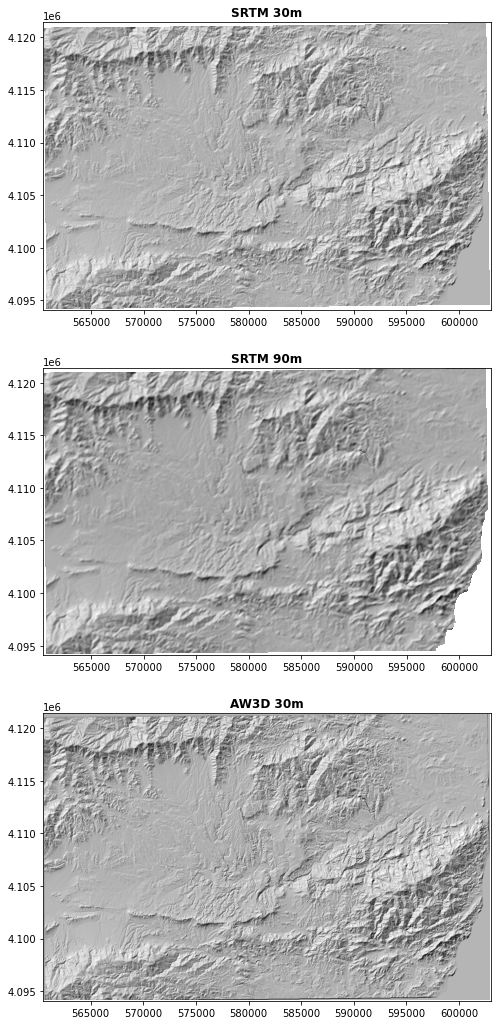

In [13]:
%matplotlib inline

f, (ax1,ax2,ax3) = plt.subplots(3, 1)

f.set_size_inches(10.5, 18) 
show(SA_SRTM_hs, ax=ax1, cmap='gray', title = "SRTM 30m")
show(SA_SRTM3_hs,ax=ax2,  cmap='gray', title = "SRTM 90m")
show(SA_AW3D_hs, ax=ax3, cmap='gray', title = "AW3D 30m")

Right, what can you see here? Hopefully the difference between SRTM1 and SRTM3 is obvious. Less obvious is the difference between SRTM1 and AW3D. We will need to zoom in to see that. To do that we need to use the subscripting functionality of `rasterio` (which allows us to subsample the underlying array)

<AxesSubplot:title={'center':'AW3D 30m'}>

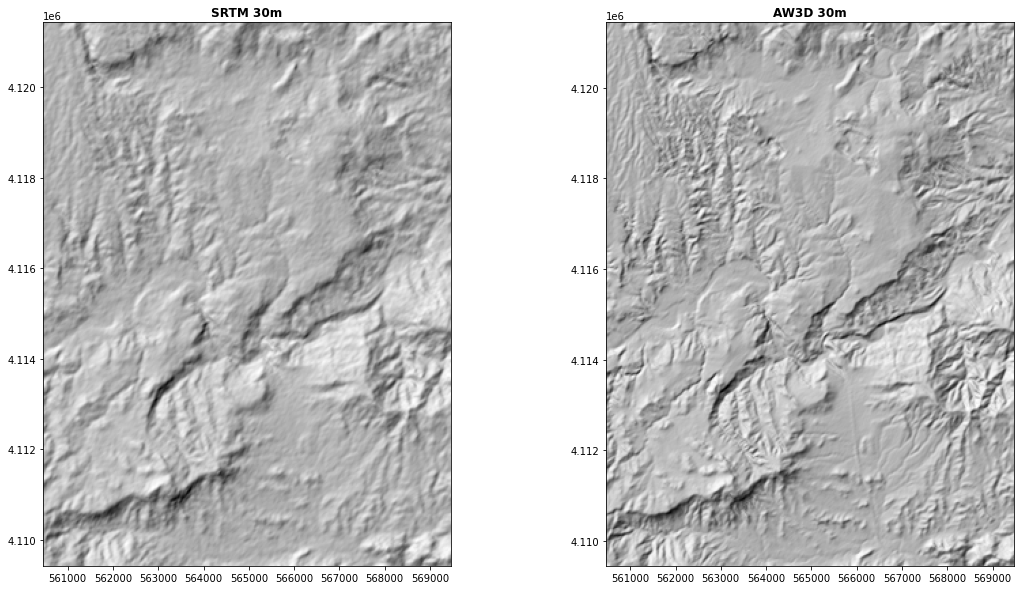

In [14]:
f, (ax1,ax2) = plt.subplots(1, 2)

f.set_size_inches(18.5, 10) 
show(SA_SRTM_hs.read(1)[300:700,600:900], ax=ax1, transform=SA_SRTM_hs.transform, cmap='gray', title = "SRTM 30m")
show(SA_AW3D_hs.read(1)[300:700,600:900], ax=ax2, transform=SA_AW3D_hs.transform, cmap='gray', title = "AW3D 30m")

Okay, so hopefully you can see from the above images that not all DEMs are created equal. SRTM was a total breakthrough in terms of producing global topographic data. But the radar only imaged the surface over a very short period so the accuracy is not as good as DEMs based on many years of stacked images (such as AW3D 30 or the Copernicus DEM). SRTM, however, is unique in that is is a snapshot of the Earth's surface in 2000, so comparisons to much later topographic data (AW3D and Copernicus) should be able to detect large changes, such as big landslides. The accuracy of these DEM is not sufficient to find small changes, however. 

*If you sign in to OpenTopography and get an api key you can try to compare AW3D 30 to the Copernicus and NASADEM topographic data.*

# Grid cell spacing on derivative data

Lets turn our attention to derived datasets. Hillshade is derived from the DEM. But we can also take the slope, or curvature, or other metrics. We will use some more **gdal** and we will also use the histogram function in `rasterio`. 

One thing to note: if you take gradient or curvature using gdal or a GIS you will get a local result: the gradient in a pixel is based only on the local pixel. This can lead to noisy results, and we think taking a neighbourhood gradient is better. But that can come in the next lesson where we show you specialised software. For now we will stick to basics. 

We are going to use the two SRTM datasets since they come from the same underlying data but are at different grid spacings.

In [15]:
!gdaldem slope RA_SRTM_UTM.tif RA_SRTM_UTM_S.tif -alg ZevenbergenThorne -p

0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
!gdaldem slope RA_SRTM3_UTM.tif RA_SRTM3_UTM_S.tif -alg ZevenbergenThorne -p

0...10...20...30...40...50...60...70...80...90...100 - done.


Now we use the `rasterio` histogram function to look at the data. 

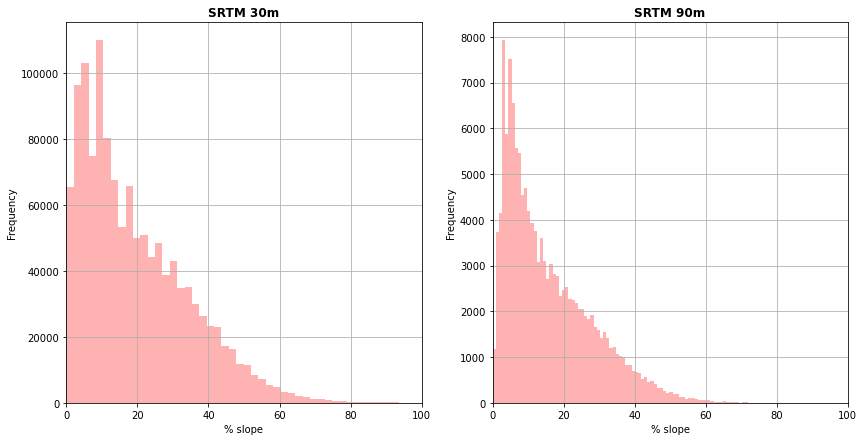

In [17]:
from rasterio.plot import show_hist

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,7))
RA_SRTM_S = rio.open("RA_SRTM_UTM_S.tif")
RA_SRTM3_S = rio.open("RA_SRTM3_UTM_S.tif")

show_hist(RA_SRTM_S, bins=100, histtype='stepfilled',lw=0.0, stacked=False, alpha=0.3,ax=ax1, title = "SRTM 30m")
ax1.set_xlabel("% slope")
ax1.set_xlim([0,100])
ax1.get_legend().remove()
show_hist(RA_SRTM3_S, bins=100, histtype='stepfilled',lw=0.0, stacked=False, alpha=0.3,ax=ax2, title = "SRTM 90m")
ax2.set_xlabel("% slope")
ax2.set_xlim([0,100])
ax2.get_legend().remove()

If you look at this data, you will see that the slope is gentler in the 90 m data. This is systematic. Coarse DEMs underestimate topographic gradients. They also give systematic biases in other derivative datasets (like curvature). *This is important because toopographic gradient has been associated with (amongst other things) landslide risk and curvature has been associated with erosion rate.*

You can read all about this in the following paper: [Grieve et al., 2016](https://esurf.copernicus.org/articles/4/627/2016/)

## What you should have learned and potential modifications

* You will have more experience downloading and warping raster data. 
* You have seen that not all datasets are of the same quality. 
* You will have seen that coarser grid spacing can lead to bias in derivative datasets, like topographic gradient.

Further steps:
* Try downloadng the Copernicus DEM and comparing that to the ALOS world 3D data. 
* Try to zoom in on a different parts of the DEM (to test if you understand how that was done). 